In [1]:
import numpy as np
import pandas as pd
import os
import gpxpy 
import gpxpy.gpx
import re
import geopy.distance
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
path = './data/'
file = 'activity_8215567101.gpx'

In [3]:
data = open(path + file).read()

lat = np.array(re.findall(r'lat="([^"]+)',data),dtype=float)
lon = np.array(re.findall(r'lon="([^"]+)',data),dtype=float)
time = re.findall(r'<time>([^\<]+)',data)

In [4]:
track = pd.DataFrame(columns = ['lat', 'lon', 'datetime'])
track.lat = lat
track.lon = lon
track.datetime = time[:-1]
track[['date', 'time']] = track['datetime'].str.split('T', 1, expand=True)
track['time'] = track['time'].str[:-1]
track

,lat,lon,datetime,date,time
0,47.237688,7.659791,2022-01-31T18:33:15.000Z,2022-01-31,18:33:15.000
1,47.237657,7.659731,2022-01-31T18:33:15.000Z,2022-01-31,18:33:15.000
2,47.237581,7.659556,2022-01-31T18:33:16.000Z,2022-01-31,18:33:16.000
3,47.237575,7.659513,2022-01-31T18:33:20.000Z,2022-01-31,18:33:20.000
4,47.237563,7.659433,2022-01-31T18:33:21.000Z,2022-01-31,18:33:21.000
...,...,...,...,...,...
938,47.237395,7.661072,2022-01-31T19:39:41.000Z,2022-01-31,19:39:41.000
939,47.237432,7.661046,2022-01-31T19:39:46.000Z,2022-01-31,19:39:46.000
940,47.237444,7.661036,2022-01-31T19:39:49.000Z,2022-01-31,19:39:49.000
941,47.237433,7.661070,2022-01-31T19:39:52.000Z,2022-01-31,19:39:52.000


In [71]:
track = pd.DataFrame(columns = ['lat', 'lon', 'datetime'])
track.lat = lat
track.lon = lon
track.datetime = time[:-1]
track['datetime'] = track['datetime'].str[:-1]
track['datetime'] = track['datetime'].str.replace('T',' ')
track['datetime'] = track['datetime'].str.replace('-','/')
track['dt'] = 0
track['dist'] = 0
track['speed'] = 0.0
for i, row in track.iterrows():
    
    datetime_object = datetime.strptime(row.datetime, '%Y/%m/%d %H:%M:%S.%f')
    track.at[i, 'datetime'] = datetime_object
    
    if i == 0:
        continue
    else:
        coords_1 = (track['lat'][i-1], track['lon'][i-1])
        coords_2 = (row.lat, row.lon)
        dist = geopy.distance.distance(coords_1, coords_2).m
        track.at[i, 'dist'] = dist
        
        dt = track['datetime'][i] - track['datetime'][i-1]
        track.at[i, 'dt'] = dt
    
    dist = track['dist'][i]
    dt = track['dt'][i].seconds
    if dt == 0:
        speed = 0
    else:
        speed = float(dist/dt)*3.6
    track.at[i,'speed'] = speed
track = track[1:]

# moving average
roll = 12

track['dt_s'] = track.dt.map(lambda x: x.seconds)
track['dist_ma'] = track['dist'].rolling(roll).mean()
track['dt_ma'] = track['dt_s'].rolling(roll).mean()
track['speed_ma'] = track['dist_ma']/track['dt_ma']*3.6
track['speed_ma2'] = track['speed'].rolling(roll).mean()
track = track.dropna()
track

,lat,lon,datetime,dt,dist,speed,dt_s,dist_ma,dt_ma,speed_ma,speed_ma2
12,47.237584,7.658491,2022-01-31 18:33:47,0:00:04,2,1.800000,4,8.083333,2.666667,10.912500,14.110000
13,47.237569,7.658192,2022-01-31 18:33:48,0:00:01,22,79.200000,1,9.500000,2.750000,12.436364,20.710000
14,47.237573,7.658065,2022-01-31 18:33:56,0:00:08,9,4.050000,8,9.000000,3.333333,9.720000,16.547500
15,47.237562,7.657908,2022-01-31 18:33:59,0:00:03,11,13.200000,3,9.666667,3.250000,10.707692,17.422500
16,47.237551,7.657806,2022-01-31 18:34:03,0:00:04,7,6.300000,4,9.750000,3.500000,10.028571,16.147500
...,...,...,...,...,...,...,...,...,...,...,...
938,47.237395,7.661072,2022-01-31 19:39:41,0:00:03,0,0.000000,3,6.166667,4.166667,5.328000,6.830714
939,47.237432,7.661046,2022-01-31 19:39:46,0:00:05,4,2.880000,5,4.833333,4.166667,4.176000,5.870714
940,47.237444,7.661036,2022-01-31 19:39:49,0:00:03,1,1.200000,3,4.666667,3.916667,4.289362,5.820714
941,47.237433,7.661070,2022-01-31 19:39:52,0:00:03,2,2.400000,3,4.333333,4.083333,3.820408,4.220714


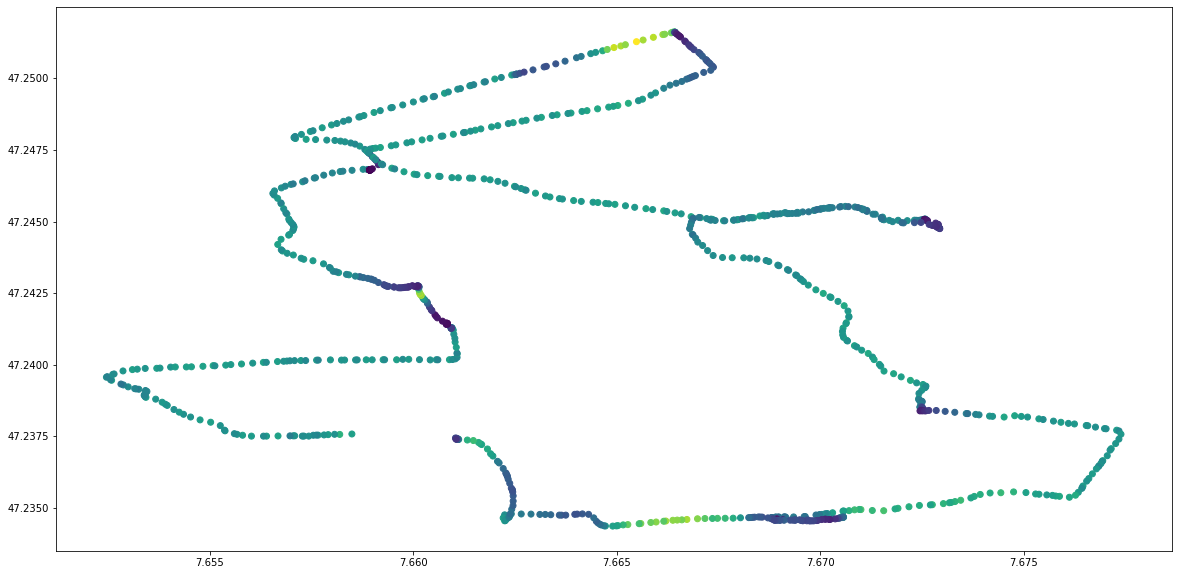

In [72]:
ax = plt.figure(figsize = (20, 10))

plt.scatter(track.lon, track.lat, c = track.speed_ma)

plt.show()

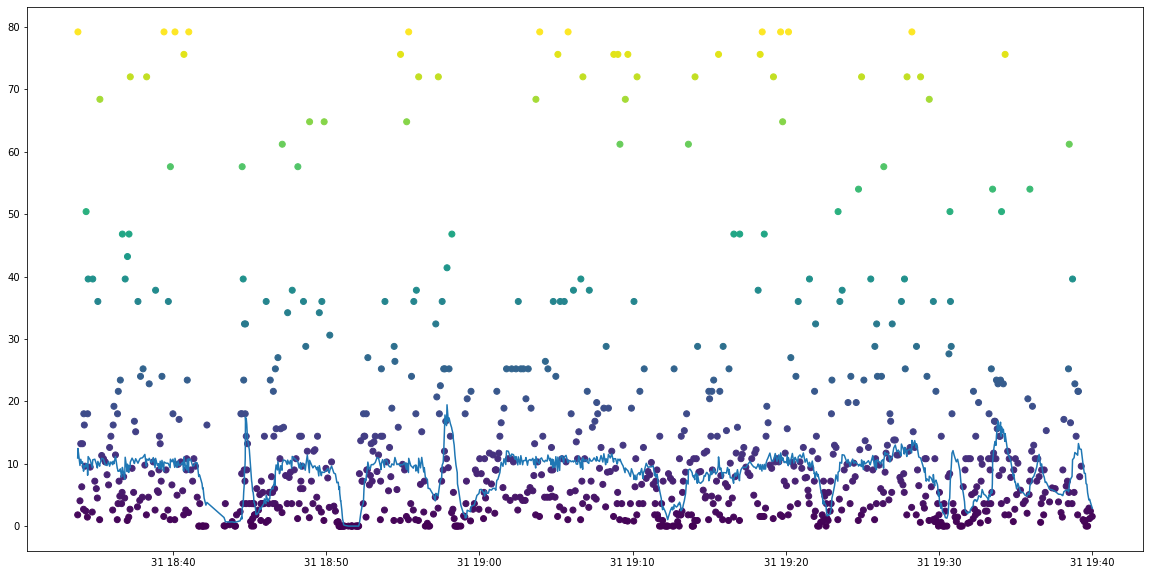

In [73]:
ax = plt.figure(figsize = (20, 10))

plt.scatter(track.datetime, track.speed, c = track.speed)
plt.plot(track.datetime, track.speed_ma)
plt.show()